In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pylab as PP
import reber as reb
import RNNv
import GRU
np.random.seed(10)

This notebook reproduce the experiment presented in *link* (part III).     
__Please note:__ Due to randomicity figures might not be exactly the same as in the paper but the conclusions are.
# Embedded Reber's grammar   
This experiment was presented in the original LSTM paper: "Long Short-Term Memory", Hochreiter and Schmidhuber.   
## Embdded Reber's grammar
The following code present how to use the reber module with embedded strings.     
It produces embedded Reber's strings and transforms them into basis vectors' sequences.

In [2]:
r = reb.get_emb_reber()
print(r)
reb.reber_to_seq(r)

BTBPVPXTVVETE


[array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.])]

## Dataset generation
We generate a dataset in the classical ways for reccurent nets,   
an example of the dataset is constitutes by two sequences.   
The goal is to predict the ith entry of the second sequence when the net   
is given the ith entry of the first one.    
We print dataset[0] to give an example.

In [3]:
DATASET_SIZE = 256
dataset = []
for d in range(DATASET_SIZE):
    reber_str = reb.get_emb_reber()
    dataset.append((reber_str, reb.reber_to_seq(reber_str)[:-1], reb.reber_to_seq(reber_str)[1:]))
dataset[0]

('BPBPVPXVPSEPE',
 [array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
  array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
  array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
  array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.]),
  array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.])],
 [array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
  array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
  array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
  array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.]),
  array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.]),
  array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.]),
  array([ 0.,  

# Vanilla RNNs
## Model Definition
We construct a Vanilla RNN with Theano.   
Same setting as in the paper: 18 hidden units.   
The Reber's alphabet is of size 7.

In [4]:
n_hidden = 18
rnn = RNNv.RNNv(7,n_hidden,7)
print('The vanilla model has: '+str(rnn.n_parameters)+' parameters.')

The vanilla model has: 594 parameters.


## Training loop
We apply a simple training process.

In [5]:
n_epochs = 1000
lr = 0.001

epsilon = 1e-5

h0 = np.zeros(n_hidden)

last_err = 0.0
for i in range(n_epochs):
    dataset_err = []
    for d in dataset:
        dataset_err.append(rnn.train_step(h0,d[1],d[2],lr)[2])
    
    mean_err = np.mean(dataset_err)
    
    if i != 0 and last_err - mean_err < 0:
        lr /= 2
    
    if i%(n_epochs/10) == 0:
        print "Iteration %d: error of %f, lr of %f" % (i, mean_err, lr)
    
    if abs(last_err-mean_err) < epsilon:
        print "Early stopping, iteration %d: error of %f, lr of %f" % (i, mean_err, lr)
        break
    
    last_err = mean_err

Iteration 0: error of 30.483889, lr of 0.001000
Iteration 100: error of 4.833431, lr of 0.001000
Iteration 200: error of 4.294545, lr of 0.001000
Iteration 300: error of 4.132812, lr of 0.001000
Iteration 400: error of 4.088785, lr of 0.001000
Iteration 500: error of 4.071428, lr of 0.001000
Iteration 600: error of 4.061998, lr of 0.001000
Iteration 700: error of 4.055786, lr of 0.001000
Iteration 800: error of 4.051148, lr of 0.001000
Iteration 900: error of 4.047409, lr of 0.001000


### Plotting results for Vanilla RNNs
We first define a plot routine for heatmaps.    

In [6]:
def reber_heatmap(rnn_p, to_show, hidden_layer=True):
    labels = []
    if not hidden_layer:
        # these labels are valid only
        # if we plot over the output layer
        labels = ['B', 'T', 'S', 'X', 'V', 'P', 'E']


    the_map = []
    for s in to_show:
        s = s.split(" ")
        seq = reb.reber_to_seq(s[-1])
        row = rnn_p.model(seq,h0)[int(hidden_layer)][-1]
        the_map.append(row)
        

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(the_map, interpolation='nearest')
    fig.colorbar(cax)
    ax.set_xticklabels(['']+labels)
    ax.set_yticklabels([''])
    plt.yticks(range(0,len(to_show)),to_show)
    plt.show()

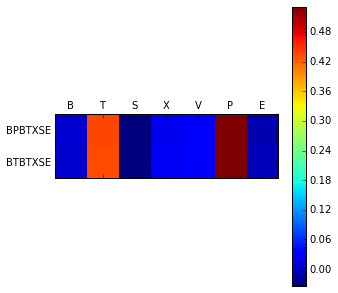

In [7]:
to_show = ['BPBTXSE','BTBTXSE']
reber_heatmap(rnn, to_show, False)

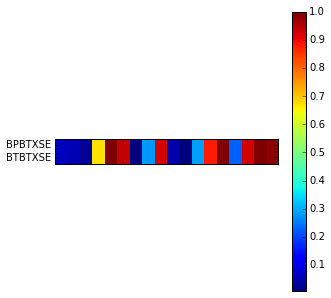

In [8]:
to_show = ['BPBTXSE','BTBTXSE']
reber_heatmap(rnn, to_show)

# GRU RNNs
## Model Definition
We construct a Vanilla RNN with Theano.   
Same setting as in the paper: 10 hidden units.   
The Reber's alphabet is of size 7.

In [9]:
n_hidden_gru = 10
gru = GRU.GRU(7,n_hidden_gru,7)
print('The gru model has: '+str(gru.n_parameters)+' parameters.')

The gru model has: 580 parameters.


## Training loop
We apply a simple training process.

In [10]:
gru.reset()
n_epochs = 1000
lr = 0.001

epsilon = 1e-5

h0 = np.zeros(n_hidden_gru)

last_err = 0.0
for i in range(n_epochs):
    dataset_err = []
    for d in dataset:
        dataset_err.append(gru.train_step(h0,d[1],d[2],lr)[2])
    
    mean_err = np.mean(dataset_err)
    
    if i != 0 and last_err - mean_err < 0:
        lr /= 2
    
    if i%(n_epochs/10) == 0:
        print "Iteration %d: error of %f, lr of %f" % (i, mean_err, lr)
    
    if abs(last_err-mean_err) < epsilon:
        print "Early stopping, iteration %d: error of %f, lr of %f" % (i, mean_err, lr)
        break
    
    last_err = mean_err

Iteration 0: error of 29.454044, lr of 0.001000
Iteration 100: error of 4.715414, lr of 0.001000
Iteration 200: error of 4.124069, lr of 0.001000
Iteration 300: error of 4.035823, lr of 0.001000
Iteration 400: error of 3.978227, lr of 0.001000
Iteration 500: error of 3.879081, lr of 0.001000
Iteration 600: error of 3.695756, lr of 0.001000
Iteration 700: error of 3.607477, lr of 0.001000
Iteration 800: error of 3.576943, lr of 0.001000
Iteration 900: error of 3.561235, lr of 0.001000


### Plotting results for GRU RNNs

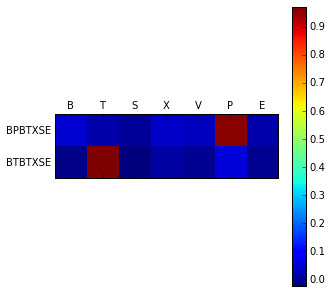

In [11]:
to_show = ['BPBTXSE','BTBTXSE']
reber_heatmap(gru, to_show, False)

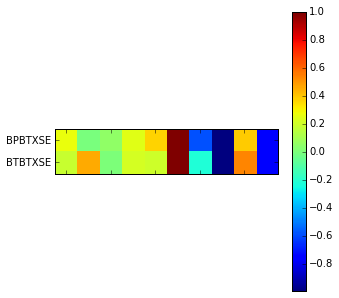

In [12]:
reber_heatmap(gru, to_show, True)

# Gradient repartition
The idea transcripted in the IARIA paper is that we cannot explain this difference of performance uniquely with learning and degenerated (vanishing/exploding) gradient arguments.     
Here are the gradient repartition of the above models.   
We plot histograms that show the repartition of the gradient parameters of both models at different scales.   
The similarity of the distribution discards the gradient propagation as the explanation for Vanilla doing poorly.
## Gradient routine
The following code grab all the gradient values of a model.

In [13]:
def grab_grad(model,n_hidden_p):
    global dataset
    to_return = []
    h0 = np.zeros(n_hidden_p)
    for i in range(len(dataset)):
        grads = np.array(model.bptt(dataset[i][1], dataset[i][2], h0))
        for grad in grads:
            for elem in grad.flatten():
                to_return.append(elem)
    return np.array(to_return)

## Vanilla's gradient VS GRU's gradient

In [14]:
grad_val_v = grab_grad(rnn,n_hidden)
grad_val_gru = grab_grad(gru,n_hidden_gru)

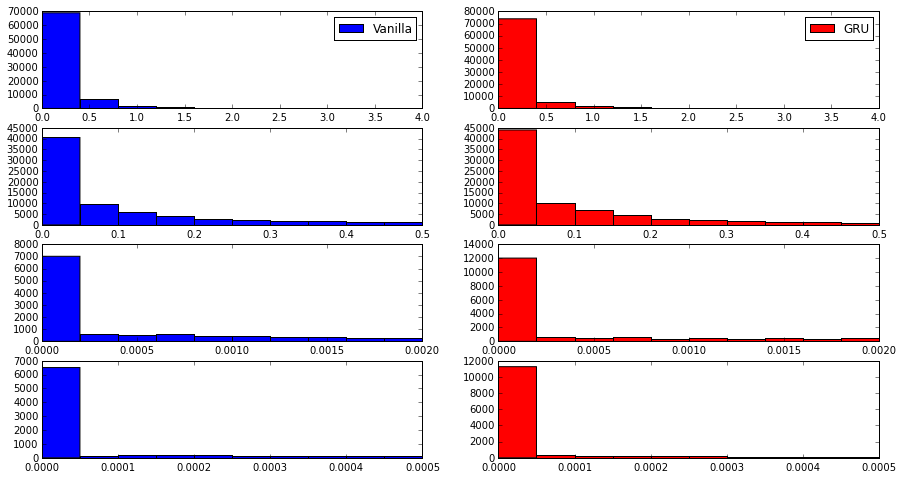

In [15]:
from matplotlib.font_manager import FontProperties
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(4, 2, 1)
ax2 = fig.add_subplot(4, 2, 3)
ax3 = fig.add_subplot(4, 2, 5)
ax4 = fig.add_subplot(4, 2, 7)
n, bins, patches = ax1.hist(grad_val_v,range=[0, 4],label='Vanilla')
ax1.legend()
n, bins, patches = ax2.hist(grad_val_v,range=[0, 0.5])
n, bins, patches = ax3.hist(grad_val_v,range=[0, 0.002])
n, bins, patches = ax4.hist(grad_val_v,range=[0, 0.0005])
ax1p = fig.add_subplot(4, 2, 2)
ax2p = fig.add_subplot(4, 2, 4)
ax3p = fig.add_subplot(4, 2, 6)
ax4p = fig.add_subplot(4, 2, 8)
n, bins, patches = ax1p.hist(grad_val_gru,range=[0, 4], color='red', label='GRU')
ax1p.legend()
n, bins, patches = ax2p.hist(grad_val_gru,range=[0, 0.5], color='red')
n, bins, patches = ax3p.hist(grad_val_gru,range=[0, 0.002], color='red')
n, bins, patches = ax4p.hist(grad_val_gru,range=[0, 0.0005], color='red')